In [1]:
# Packages
import pandas as pd
import math 
import numpy as np 
import seaborn as sns 
import os
import datetime as dt 
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import pickle
import matplotlib.cm as cm
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

## Model 

### Summary

We model the ROI's for an SP with $M$ sectors following the introduction of the SDM Policy with slope $ m = \frac{2}{7}$ and slope $ m = 1$ within 4 different macroeconomic regimes. In this model, we assume the extreme case of *power conservation* in which the SP terminates $(1-\frac{1}{max(SDM)})$ of its sectors and reonboard $\frac{1}{max(SDM)}$ for the maximum duration, effectively maintaining their power but with power consolidated in a smaller number of sectors  

1. FIL Conserved & Group Terminates
2. FIL Conserved & Group Does Not Terminate 
3. Data Conserved & Group Terminate 
4. Data Conserved & Group Does Not Terminate

We define the following: 
- $\textrm{T}$ be the event that the group collective decides to terminate 
- $\textrm{N}$ be the event that the group collectively decides not to termiante
- $\textrm{t}$ be the event that an individal sp decides to terminate $(1-\frac{1}{max(SDM)})$ of its sector's and reonboard $\frac{1}{max(SDM)}$ for the maximum duration
- $\textrm{n}$ be the event that an individual SP decides not to terminate
- $S$ - Salvage Value of a Sector
- $C$ - Reseal Cost of a Sector

We are interested in two ROI ratios for each conservation regime, and, ideally want the following conditions in the respective regimes

#### Termination Regime 
$$ \frac{ROI(\textrm{t|T})}{ROI(\textrm{n|T})} < 1 $$

#### Non-Termination Regime

$$ \frac{ROI(\textrm{t|N})}{ROI(n|N)} < 1 $$

#### where: 

$$ ROI(\textrm{t|T,N}) = \frac{E[BR_{terminate}] + (IP_{Seal} - IP_{Reseal}) - t_{fee} - C + S}{IP_{Seal}} $$

and: 

$$ ROI(\textrm{n|T,N}) = \frac{E[BR_{noTermination}]}{IP_{Seal}} $$

Note: 
- $E[BR_{terminate}] = E[BR_{noTermination}]$ since the SP **maintains power** when she terminates and reonboards with the maximum SDM (2x) 
- $IP_{Seal}$ is the initial pledge required for sealing **2 sectors** 
- $IP_{Reseal}$ is the initial pledge required for sealing **1 sector** with a **2x SDM multiplier**



In [2]:
GiB = 2**30
TiB = 2**40 

In [3]:
## Get Data
def get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/',
                  burn_boost='',
                  lock_target='',
                  plt_regime='',
                  duration_yr='', 
                  rbp_i= '',
                  rr_i= '',
                  filplus_i='',
                  duration_slope=0.285,
                  is90=True):
    group_terminate_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'jump', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
    group_terminate_key = 'SDM-(%s)' % (group_terminate_key,)
    
    group_no_terminate_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'smooth', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
    group_no_terminate_key = 'SDM-(%s)' % (group_no_terminate_key,)
    
    if is90:
        with open(path + 'duration_loop_results_90d.pkl', 'rb') as f:
            results = pickle.load(f)
    else: 
        with open(path + 'duration_loop_results_terminationfee140days.pkl', 'rb') as f:
            results = pickle.load(f)


    dfs_dict = {}
    dfs_dict['Group_Terminates'] = results[group_terminate_key]
    dfs_dict['Group_No_Terminates'] = results[group_no_terminate_key]
    
    return dfs_dict
    

In [84]:
## Compute ROI Ratios for given regime

def compute_roi_ratios(dfs_dict_regime, 
                       sdm_slope=0.285, 
                       termination_cap=90): 
    
    num_sectors = 18
    
    if sdm_slope == 0.285:
        max_sdm = 2
    elif sdm_slope == 1: 
        max_sdm = 9/2
    
    intervention_date = pd.to_datetime('2023-02-15')
    decision_date = intervention_date
    start_date = pd.to_datetime('2022-04-01')
    reward_years = 1
    end_date = decision_date + dt.timedelta(365 * reward_years)
    seal_date = start_date
    salvage_value = num_sectors * (1-1/max_sdm) * 1/4 * 0.4 #Salvage Value for a 32 GiB Sector in FIL Space 
    reseal_cost = num_sectors * (1/max_sdm) * 0.55 * GiB/TiB * 32 * 1.2 #Scale Gas Cost by 20% to include hardware/energy cost to resealing

    df = dfs_dict_regime['rbp_roi']
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)

    termination_mask = (df.index>=seal_date) & (df.index < decision_date)
    rewards_mask = (df.index>=seal_date) & (df.index < end_date)

    ROI_ratios = {}

    decision_dates = [intervention_date]
    months = 6
    for i in range(months): 
        decision_dates.append(decision_dates[-1] + dt.timedelta(30))

    results_roi_ratios = {}

    for idx,decision_date in enumerate(decision_dates):
        seal_date = start_date + dt.timedelta(30*idx)
        roi_ratios_dict = {}
        IP_dict = {}
        end_date = decision_date + dt.timedelta(365 * reward_years)
        termination_mask = (df.index>=seal_date) & (df.index < decision_date)
        rewards_mask = (df.index>=seal_date) & (df.index < end_date)
        #results_mask = (df.index>=start_date) & (df.index<decision_date)

        while seal_date < decision_date: 

            ## Compare ROI Ratios for keeping (1-1/max(sdm)) sectors vs salvage value for 1 and then resealing max power (maintain power)
            IP_seal = num_sectors * df[df.index==seal_date]['day_pledge_per_QAP'].values
            IP_reseal = num_sectors * df[df.index==decision_date]['day_pledge_per_QAP'].values

            ## Calc ROI Terminate
            block_reward_terminate = num_sectors * df[rewards_mask]['day_rewards_per_sector'].values.sum()
            termination_fee = num_sectors * df[termination_mask]['day_rewards_per_sector'].head(termination_cap).values.sum()
            ROI_terminate = ((block_reward_terminate) + (IP_seal - IP_reseal) - termination_fee + salvage_value - reseal_cost)/IP_seal

            ## Calc ROI No Temrinate    
            block_reward_no_terminate = num_sectors * df[rewards_mask]['day_rewards_per_sector'].values.sum()
            ROI_no_terminate = block_reward_no_terminate/IP_seal

            ratio = float(ROI_terminate/ROI_no_terminate)

            roi_ratios_dict[seal_date] = ratio

            seal_date += dt.timedelta(1)

        roi_ratios_df = pd.DataFrame.from_dict(roi_ratios_dict, orient='index')
        roi_ratios_df.rename(columns={0: str(decision_date)}, inplace=True)
        #roi_ratios_df.columns = decision_date
        results_roi_ratios[decision_date] = roi_ratios_df
        
    return results_roi_ratios

In [170]:
# Plotting results for Various Conservation Regimes and Termmination Fee Caps 
def plot_termination_results(termination_cap=90, 
                             plt_regime='fil_conserved'):
    # Load and compute SDM Slope 0.285 Results 
    duration_slope = 0.285
    burn_boost = 1
    lock_target = 0.3 
    duration_yr = 3
    rbp_i = 'last_historical'
    rr_i = rbp_i
    filplus_i = 0.6
    dfs_dict_FIL_Conserved_minSlope = get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/', 
                                                     burn_boost=burn_boost,
                                                     lock_target=lock_target, plt_regime=plt_regime, duration_yr=duration_yr, rbp_i=rbp_i,rr_i=rr_i,filplus_i=filplus_i,duration_slope=duration_slope,is90=True)

    results_roi_ratios_FIL_Conserved_group_terminates_minSlope = compute_roi_ratios(dfs_dict_FIL_Conserved_minSlope['Group_Terminates'], 
                                                                                    sdm_slope=duration_slope,
                                                                                    termination_cap=termination_cap)
    results_roi_ratios_FIL_Conserved_group_no_terminates_minSlope = compute_roi_ratios(dfs_dict_FIL_Conserved_minSlope['Group_No_Terminates'], 
                                                                                      sdm_slope=duration_slope,
                                                                                      termination_cap=termination_cap)

    # Load and Compute SDM Slope Results 
    burn_boost = 1
    lock_target = 0.3 
    duration_yr = 3
    rbp_i = 'last_historical'
    rr_i = rbp_i
    filplus_i = 0.6
    duration_slope = 1
    dfs_dict_FIL_Conserved_maxSlope = get_regime_dfs(path=os.getcwd() + '/results/incentive_to_terminate/', burn_boost=burn_boost,lock_target=lock_target,plt_regime=plt_regime,duration_yr=duration_yr, rbp_i=rbp_i,rr_i=rr_i,filplus_i=filplus_i,duration_slope=duration_slope,is90=True)
    
    results_roi_ratios_FIL_Conserved_group_terminates_maxSlope = compute_roi_ratios(dfs_dict_FIL_Conserved_maxSlope['Group_Terminates'], 
                                                                                   sdm_slope=duration_slope, 
                                                                                   termination_cap=termination_cap)
    results_roi_ratios_FIL_Conserved_group_no_terminates_maxSlope = compute_roi_ratios(dfs_dict_FIL_Conserved_maxSlope['Group_No_Terminates'], 
                                                                                      sdm_slope=duration_slope, 
                                                                                      termination_cap=termination_cap)

    ## Plot
    sns.set(rc = {'figure.figsize':(10,6)})

    fig, axs = plt.subplots(2,1, sharey=True, sharex=True)
    sns.set_style('whitegrid', {'axes.edgecolor': '.6', 'grid.color': '.6'})

    ## Plot Results for Group Terminates 
    results_roi_ratios_minSlope = results_roi_ratios_FIL_Conserved_group_terminates_minSlope
    results_roi_ratios_maxSlope = results_roi_ratios_FIL_Conserved_group_terminates_maxSlope

    alphas = np.linspace(1,0.2,len(results_roi_ratios_minSlope.keys()))
    for idx,decision_date in enumerate(results_roi_ratios_minSlope.keys()):
        sns.lineplot(x=results_roi_ratios_minSlope[decision_date].index, y=str(decision_date), data=results_roi_ratios_minSlope[decision_date], c='b', alpha=alphas[idx],label=decision_date.strftime('%Y-%m-%d'), legend=False, ax=axs[0])

    for idx,decision_date in enumerate(results_roi_ratios_maxSlope.keys()):
        sns.lineplot(x=results_roi_ratios_maxSlope[decision_date].index, y=str(decision_date), data=results_roi_ratios_maxSlope[decision_date], c='orange', alpha=alphas[idx],legend=False, ax=axs[0])

    axs[0].axhline(1, c='r')
    axs[0].set_title('ROI Ratio Terminate/Not Terminate in Termination Regime')
    axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='SP Decision Date, SDM=0.285')
    axs[0].set_xlabel('Initial Sector Commitment Date')
    axs[0].set_ylabel('ROI Ratio')

    ## Plot Results Group Does Not Terminate 

    results_roi_ratios_minSlope = results_roi_ratios_FIL_Conserved_group_no_terminates_minSlope
    results_roi_ratios_maxSlope = results_roi_ratios_FIL_Conserved_group_no_terminates_maxSlope
    alphas = np.linspace(1,0.2,len(results_roi_ratios_minSlope.keys()))
    for idx,decision_date in enumerate(results_roi_ratios_minSlope.keys()):
        sns.lineplot(x=results_roi_ratios_minSlope[decision_date].index,y=str(decision_date),data=results_roi_ratios_minSlope[decision_date], c='b', alpha=alphas[idx],legend=False, ax=axs[1])

    for idx,decision_date in enumerate(results_roi_ratios_maxSlope.keys()):
        sns.lineplot(x=results_roi_ratios_maxSlope[decision_date].index, y=str(decision_date), data=results_roi_ratios_maxSlope[decision_date], c='orange', alpha=alphas[idx],label=decision_date.strftime('%Y-%m-%d'), legend=False, ax=axs[1])

    axs[1].axhline(1, c='r')
    axs[1].set_title('ROI Ratio Terminate/Not Terminate in No Termination Regime')
    axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.8), title='SP Decision Date, SDM=1.000')
    axs[1].set_xlabel('Initial Sector Commitment Date')
    axs[1].set_ylabel('ROI Ratio')

    plt.suptitle(str(plt_regime) + ',Termination_Fee_Cap = ' + str(termination_cap) + ' days')
    

### FIL Conserved Regime

#### Termination Cap - 90 Days

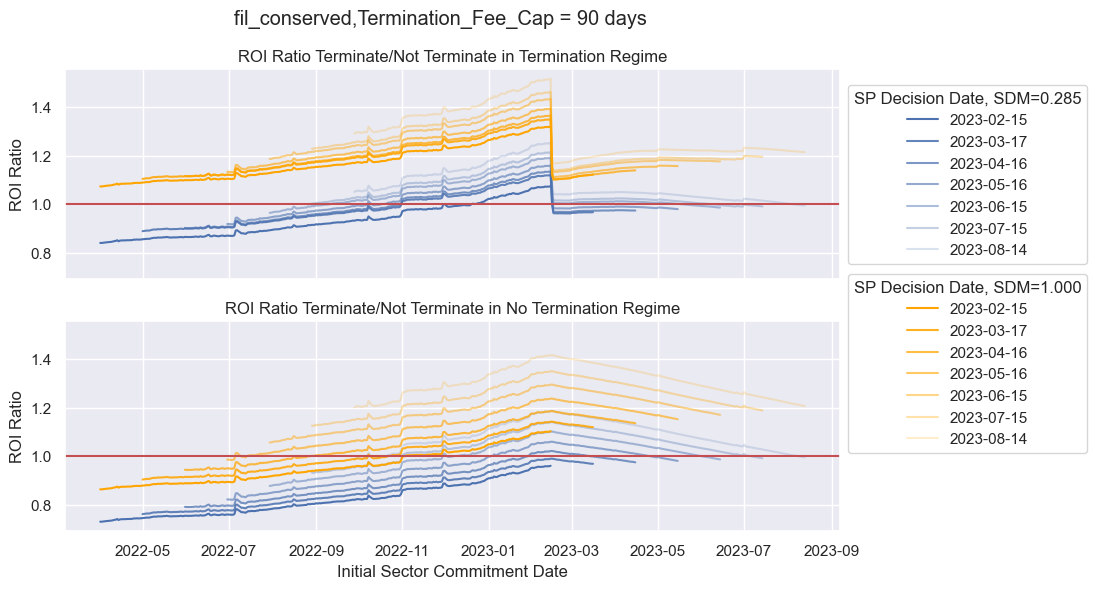

In [191]:
termination_cap=90
plt_regime='fil_conserved'
plot_termination_results(termination_cap=90, 
                             plt_regime='fil_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')

#### Termination Cap - 180 Days

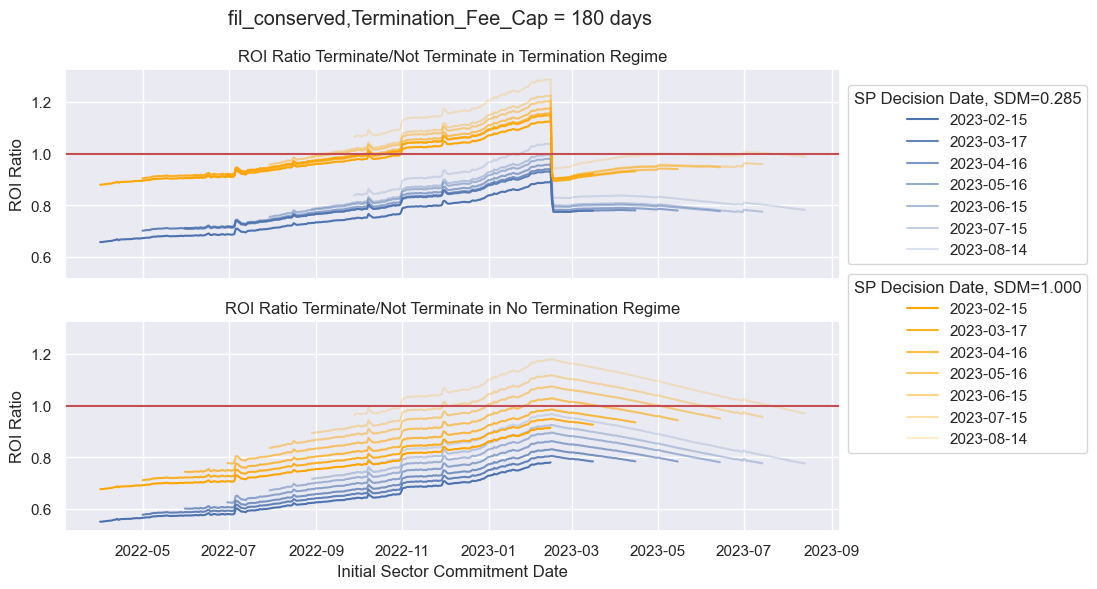

In [192]:
termination_cap=180
plt_regime='fil_conserved'
plot_termination_results(termination_cap=180, 
                             plt_regime='fil_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')

#### Termination Cap - 270 Days

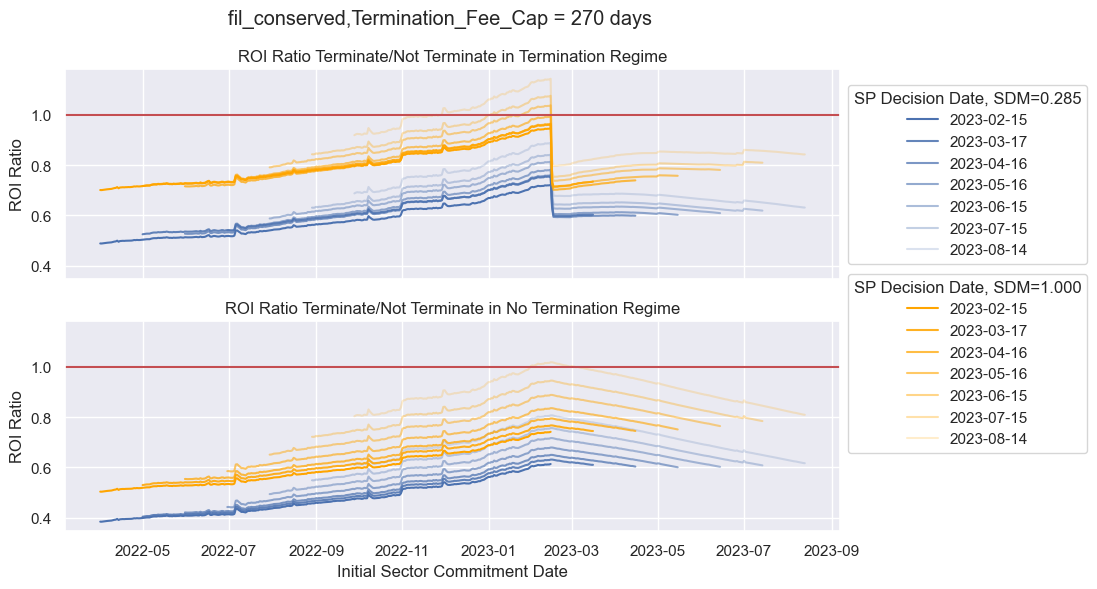

In [193]:
termination_cap=270
plt_regime='fil_conserved'
plot_termination_results(termination_cap=270, 
                             plt_regime='fil_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')

### Data Conserved Regime 

#### Termination Cap - 90 Days

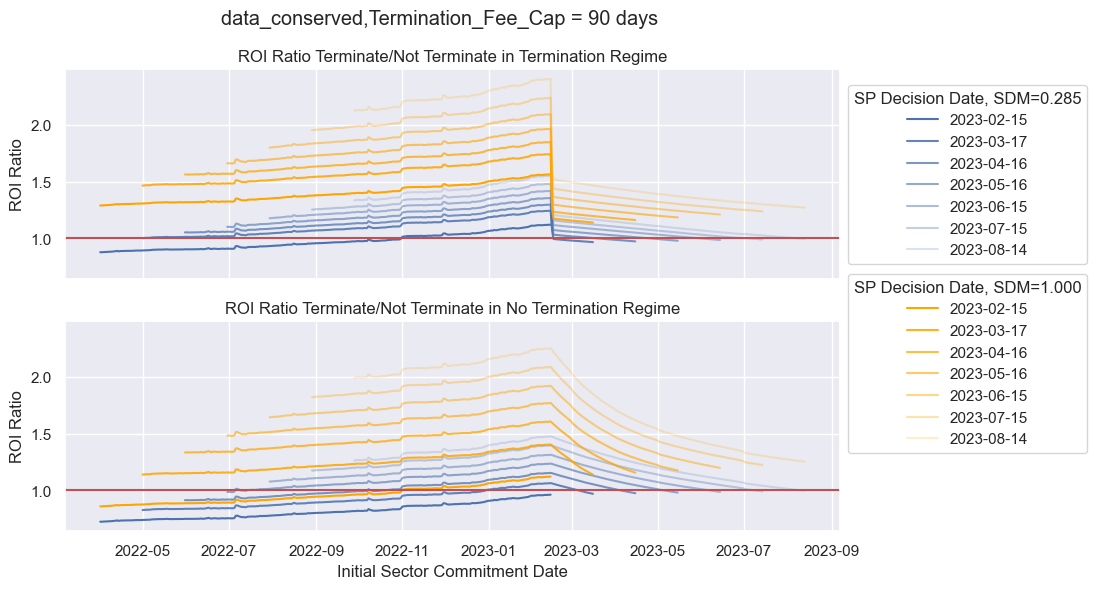

In [194]:
termination_cap=90
plt_regime='data_conserved'
plot_termination_results(termination_cap=90, plt_regime='data_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')

#### Termination Cap. - 180 Days

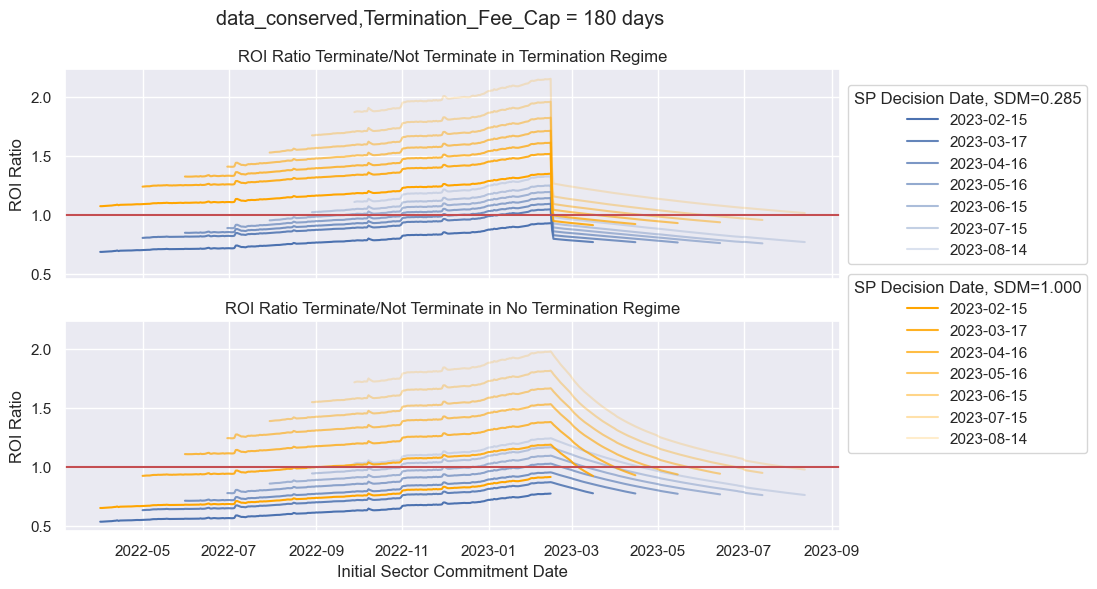

In [195]:
termination_cap=180
plt_regime='data_conserved'
plot_termination_results(termination_cap=180, 
                             plt_regime='data_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')

#### Termination Cap - 270 Days

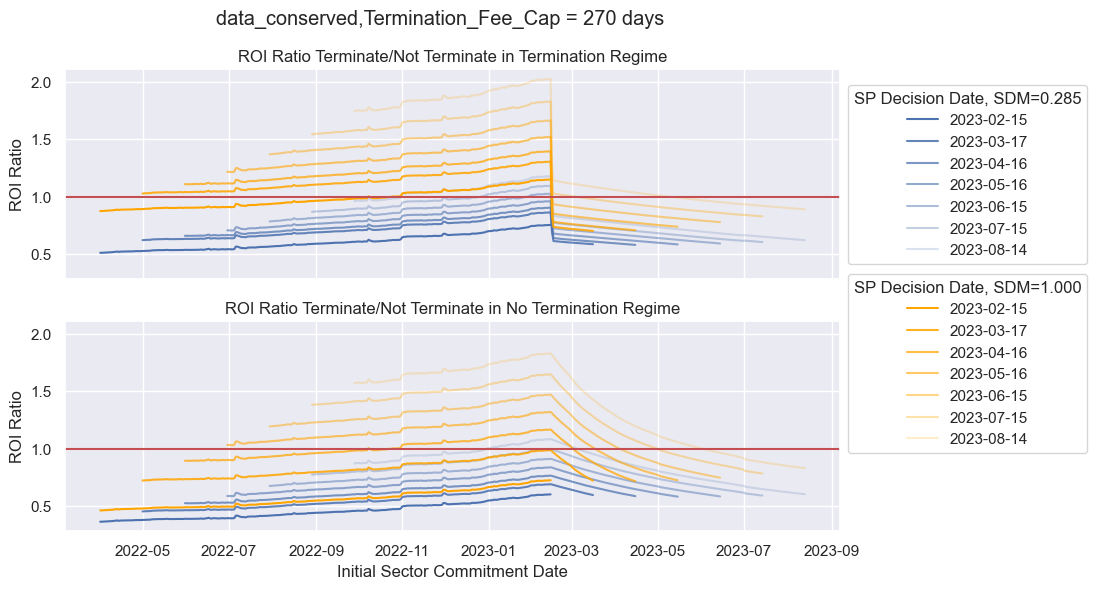

In [196]:
termination_cap=270
plt_regime='data_conserved'
plot_termination_results(termination_cap=270, 
                             plt_regime='data_conserved')
plt.savefig(plt_regime+ '_'+str(termination_cap), bbox_inches='tight')